# A Closer Look at Life Expectancy : Key Findings and Implications  
Life Expectancy, representing the average lifespan of a newborn infant, and Birth rate, reflecting the number of births per thousand individuals, are crucial indicators of societal well-being and development.

With this analysis, we will investigate the relationship between Life Expectancy and Birth Rate, as well as the impact of Income Level on Life Expectancy.  
Our main objectives are to answer three key questions:  
> 1. How does Birth Rate impact Life Expectancy?
> 2. What influence does a country's Income Level have on Life Expectancy?
> 3. Can we categorize countries based on their Life Expectancy patterns?

## About the data
The two dataset used in this analysis can be downloaded from [WorldBank Birth Rate data](https://data.worldbank.org/indicator/SP.DYN.CBRT.IN) and [WorldBank Life Expectancy data](https://data.worldbank.org/indicator/SP.DYN.LE00.IN).  
The dataset are licensed under License CC BY-4.0.  

The excel sheets contain data on Birth Rate and Life Expectancy of 217 countries from the year 1960 to 2020, along with each countries Income Group and Geographic Region.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from collections import Counter, defaultdict
from sklearn.metrics import pairwise_distances_argmin
from sklearn import linear_model
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from matplotlib.colors import to_hex

## 1. Load, examine and clean the data

In [2]:
# Read and load the excel sheets
folder_path = 'D:/PortfolioProjects/BirthRatevsLifeExpectancy/'
data_birth_rate = pd.read_excel(folder_path + 'birthrate.xls')
data_life_expectancy= pd.read_excel(folder_path + 'lifeexpectancy.xls')

del folder_path

In [3]:
data_birth_rate.head()
# data_life_expectancy.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,Region,Income Group
0,Aruba,ABW,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,33.883000,32.831000,31.649000,30.416000,29.147000,27.889000,...,13.533000,12.428000,12.300000,11.530000,9.881000,9.138000,8.102000,NaN,Latin America & Caribbean,High income
1,Africa Eastern and Southern,AFE,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,47.438554,47.530552,47.597558,47.636140,47.645480,47.667660,...,36.028330,35.613326,35.189027,34.892547,34.611033,34.341460,33.916755,NaN,0,0
2,Afghanistan,AFG,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,50.340000,50.443000,50.570000,50.703000,50.831000,50.872000,...,39.105000,38.803000,37.936000,37.342000,36.927000,36.466000,36.051000,NaN,South Asia,Low income
3,Africa Western and Central,AFW,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,47.325476,47.421051,47.529223,47.531029,47.511923,47.468568,...,39.335352,38.859210,38.393100,37.881661,37.447087,37.027834,36.615730,NaN,0,0
4,Angola,AGO,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,51.026000,51.282000,51.316000,51.323000,51.282000,51.282000,...,42.676000,42.020000,41.377000,40.810000,40.236000,39.725000,39.271000,NaN,Sub-Saharan Africa,Lower middle income


After examining the data, we will perfom the following to clean and arrange the data:  
> 1. Remove rows with integer values for 'Region' & 'Income Group' columns  
> 2. Remove rows with missing values for 'Region' column  
> 3. Add 'Income Level' for Venezuala  
> 4. Filter out columns which are not required for analysis

In [4]:
# Filter out rows with integer values for 'Region' and 'Income Group'
data_birth_rate = data_birth_rate[data_birth_rate['Region'].apply(lambda x: type(x) != int)]
data_life_expectancy = data_life_expectancy[data_life_expectancy['Region'].apply(lambda x: type(x) != int)]

# Remove rows with missing values
data_birth_rate = data_birth_rate.dropna(subset=['Region'])
data_life_expectancy = data_life_expectancy.dropna(subset=['Region'])

# Add Income Level for Venezula
data_birth_rate.iloc[206, 67] = 'Lower middle income'
data_life_expectancy.iloc[206, 67] = 'Lower middle income'

# Filter out unwanted columns
data_birth_rate = data_birth_rate.drop(['Country Code', 'Indicator Name', 'Indicator Code', '2021'], axis=1)
data_life_expectancy = data_life_expectancy.drop(['Country Code', 'Indicator Name', 'Indicator Code', '2021'], axis=1)

## 2. Encode Categorical Variable into Numerical Variable 
We are interested in analyzing the impact of' **Income Level** on **Life Expectancy**.  
In this dataset, Income Level is a categorical variable divided into 4 categories - High income, Upper middle income, Lower middle Income & Low income.  
We will convert it into numerical variable as Regression analysis requires features to be continous.


In [5]:
mapping = {'High income': 3, 'Upper middle income': 2, 'Lower middle income': 2, 'Low income': 1}
data_birth_rate['Income Level'] = data_birth_rate['Income Group'].replace(mapping)
data_life_expectancy['Income Level'] = data_life_expectancy['Income Group'].replace(mapping)

del mapping

## 3. Bivariate Linear Regression
Let us first explore the relationship between Birth Rate and Life Expectancy.  
We will use a Bivariate Linear model to achieve this.  
The model assumes a linear relationship between the predictor variable (Birth Rate, in our case) and the response variable (Life Expectancy).

[-0.66766382]


Text(0.92, 0.34, 'Life Expectancy is negatively\ncorrelated to Birth Rate.\nRegression Coeff. = -0.67\n\nBirth Rate captures 76% of\nvariance in Life Expectancy.')

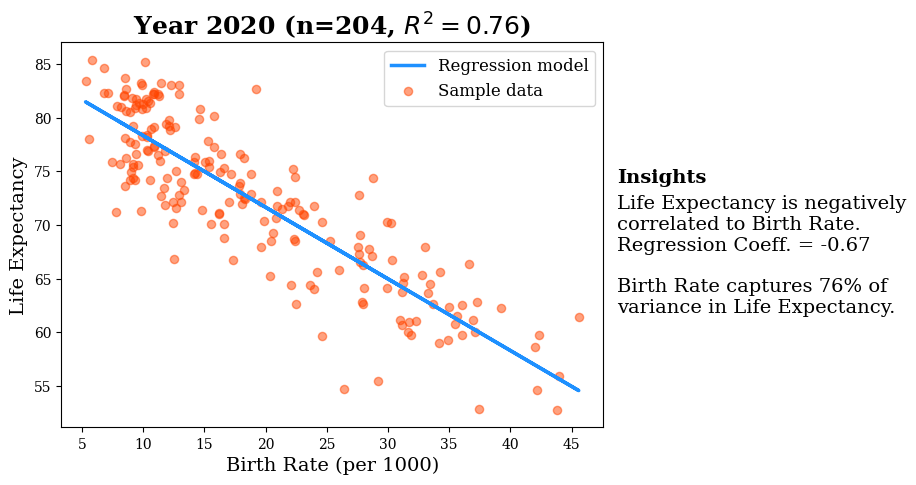

In [21]:
# Prepare 2020 year data for modeling
x = data_birth_rate['2020'].values
y = data_life_expectancy['2020'].values

mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

x_reshaped = x.reshape(-1,1)

ols = linear_model.LinearRegression()
model = ols.fit(x_reshaped, y)
response = model.predict(x_reshaped)
print(model.coef_)
r2 = model.score(x_reshaped, y)

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(x_reshaped, response, label='Regression model', color='dodgerblue', linewidth=2.5)
ax.scatter(x_reshaped, y, label='Sample data', color='orangered', facecolor='orangered', alpha=0.5, s=35)
ax.set_title('Year 2020 (n=' + str(x.size) + ', ' + '$R^2= %.2f$' % r2 + ')', fontsize=18, fontweight='bold')
ax.set_xlabel('Birth Rate (per 1000)', fontsize=14)
ax.set_ylabel('Life Expectancy', fontsize=14)
ax.legend(fontsize=12)

plt.rcParams['font.family'] = 'serif'

fig.text(0.92, 0.60, "Insights", fontfamily='serif', fontweight='bold', fontsize=14)
fig.text(0.92, 0.34, 
         '''Life Expectancy is negatively
correlated to Birth Rate.
Regression Coeff. = -0.67

Birth Rate captures 76% of
variance in Life Expectancy.''',  fontfamily='serif', fontsize=14)

# del ols, model, response, r2
# del fig, ax, mask, x, y, x_reshaped


For the year 2020, we found a negative relationship between Birth Rate and Life Expectancy.    
As Birth Rate increases, Life Expectancy decreases.  

Let us now examine whether a comparable relationship can be observed using data from previous years.  
We will narrow our attention to one year from each decade within the dataset, which covers the period from 1960 to 2020.

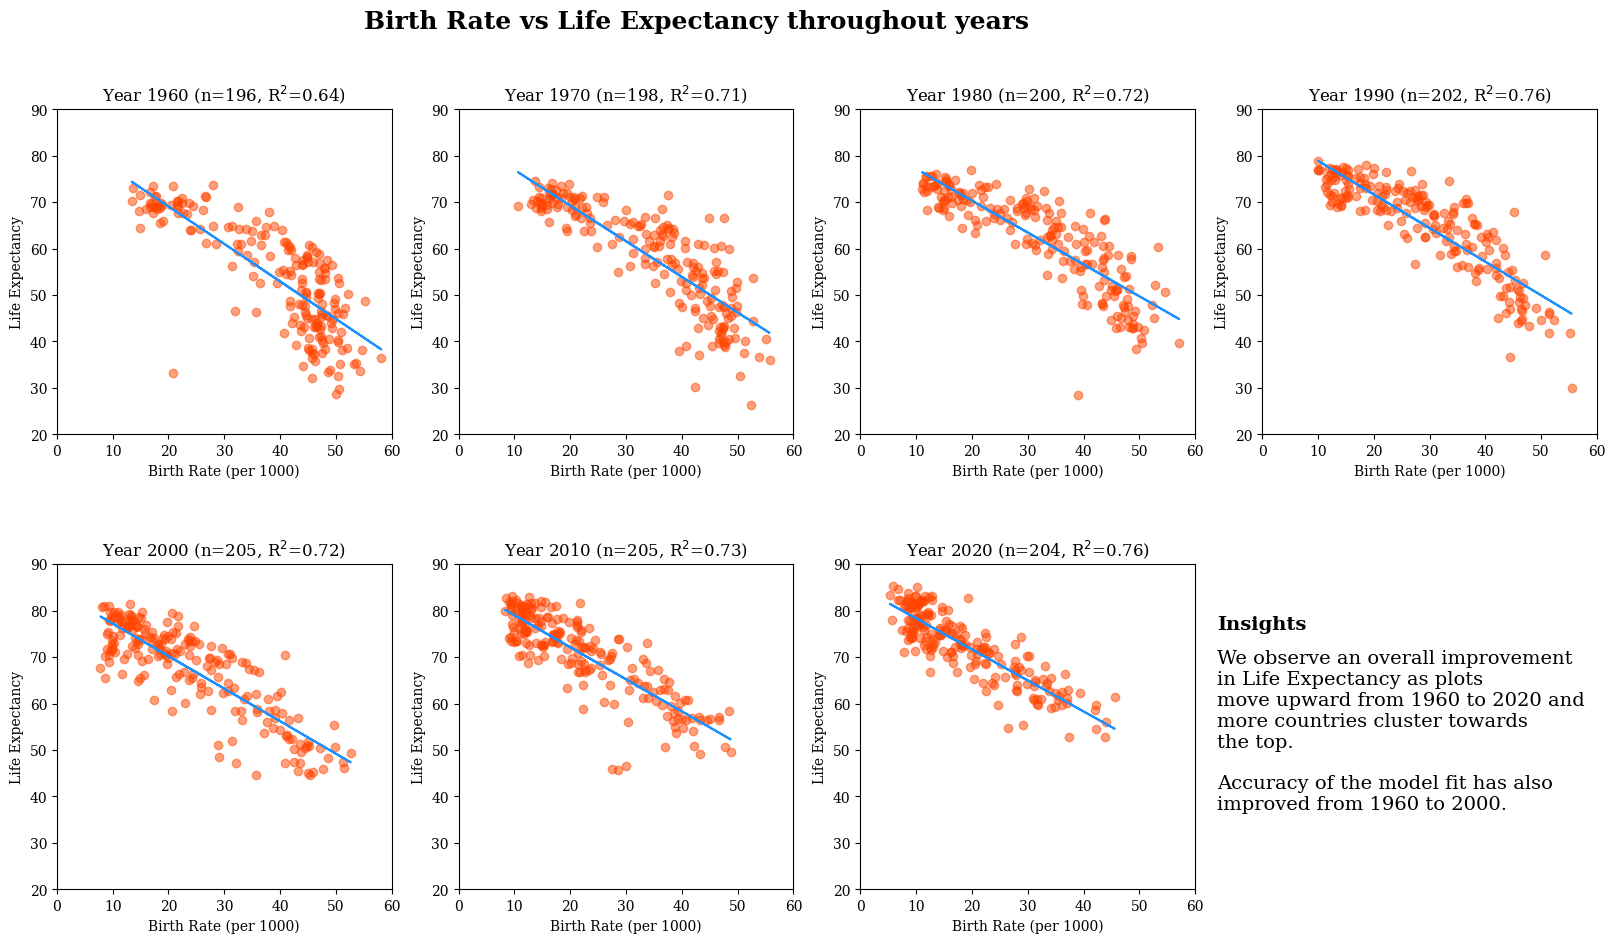

In [28]:
fig,axs = plt.subplots(2,4, figsize=(20,10))
ols = linear_model.LinearRegression()

idx = 0
years =['1960', '1970', '1980', '1990', '2000', '2010', '2020']

for i in range(2):
    for j in range(4):
        if(idx==7):
            break
        curr_year = years[idx]
        x = data_birth_rate[curr_year].values
        y = data_life_expectancy[curr_year].values
        mask = ~np.isnan(x) & ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        x_reshaped = x.reshape(-1,1)

        model = ols.fit(x_reshaped, y)
        response = model.predict(x_reshaped)
        r2 = model.score(x_reshaped, y)

        axs[i,j].plot(x_reshaped, response, color='dodgerblue', label='Regression model')
        axs[i,j].scatter(x_reshaped, y, edgecolor='orangered', facecolor='orangered', alpha=0.5, label='Sample data')
        axs[i,j].set_title(f"Year {curr_year} (n={x.size}, R$^2$={r2:.2f})")
        #ax.set_title('Year 2020 (n=' + str(x.size) + ', ' + '$R^2= %.2f$' % r2 + ')', fontsize=18, fontweight='bold')

        del x, y, mask, x_reshaped, model, response, r2
        idx = idx +1

axs[1,3].remove()

# add x and y labels to all subplots
for ax in axs.flat:
    ax.set_xlabel('Birth Rate (per 1000)')
    ax.set_ylabel('Life Expectancy')
    ax.set_xlim([0, 60])
    ax.set_ylim([20, 90])

plt.rcParams['font.family'] = 'serif'
plt.subplots_adjust(hspace=0.4, top=0.88, bottom=0.1, left=0.18, right=0.95)

fig.suptitle('Birth Rate vs Life Expectancy throughout years', fontsize=18, fontweight='bold', ha='center')
fig.text(0.76, 0.36, "Insights", fontfamily='serif', fontweight='bold', fontsize=14)
fig.text(0.76, 0.18, 
         '''We observe an overall improvement
in Life Expectancy as plots
move upward from 1960 to 2020 and
more countries cluster towards
the top.

Accuracy of the model fit has also
improved from 1960 to 2000.''',  fontfamily='serif', fontsize=14)

plt.show()

del ax, axs, curr_year, fig, i, idx, j, ols, years

From 1960 to 2020, the figure shows countries moving upward, indicating a rise in Life Expectancy, and  
we also observe more countries dispersing towards the higher end.

## 4. Multivariate Linear Regression
Previously we saw that Birth Rate alone can explain 76% of variance while predicting Life Expectancy,  
We now want to extend our mdoel by introducing a second feature which is the Income Level of each countries.

In [8]:
# Prepare data for multi-variate regression analysis
year2020 = pd.DataFrame(data_birth_rate, columns=['Country Name', 'Income Level', 'Income Group', 'Region', '2020'])
year2020 = year2020.rename(columns={'2020': 'BR'})
year2020['LE'] = data_life_expectancy[['2020']]
year2020.dropna(subset=['BR'], inplace=True)
year2020.dropna(subset=['LE'], inplace=True)

X = year2020[['BR', 'Income Level']].values.reshape(-1,2)
Y = year2020['LE']

# Prepare model for visualization
x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(5, 50, 30) # range of birth rate values
y_pred = np.linspace(1, 3, 30)  # range of Income level values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Train
ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

# Evaluate
r2 = model.score(X, Y)

del model, model_viz,ols, X

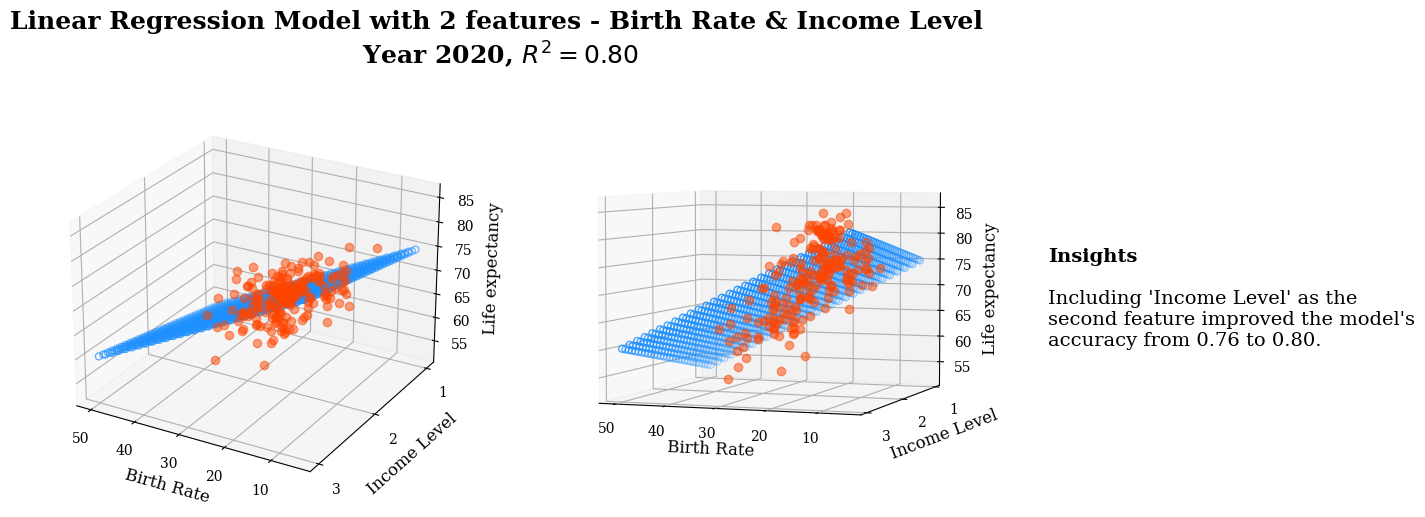

In [9]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
axes = [ax1, ax2]

for ax in axes:
    ax.plot(x, y, z, color='orangered', zorder=10, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=25, edgecolor='dodgerblue')
    ax.set_xlabel('Birth Rate', fontsize=12)
    ax.set_ylabel('Income Level', fontsize=12)
    ax.set_zlabel('Life expectancy', fontsize=12)
    ax.locator_params(nbins=5, axis='x')
    ax.locator_params(nbins=3, axis='y')

ax1.view_init(elev=25, azim=120)
ax2.view_init(elev=4, azim=110)

plt.rcParams['font.family'] = 'serif'

fig.suptitle('Linear Regression Model with 2 features - Birth Rate & Income Level\n Year 2020, $R^2 = %.2f$' % r2, 
             fontsize=18, fontweight='bold')
fig.text(0.96, 0.56, "Insights", fontfamily='serif', fontweight='bold', fontsize=14)
fig.text(0.96, 0.42, 
         '''Including 'Income Level' as the
second feature improved the model's
accuracy from 0.76 to 0.80.''',  fontfamily='serif', fontsize=14)
plt.subplots_adjust(wspace=0.25)

del ax, ax1, ax2, fig, axes
del x, x_pred, xx_pred, Y, y, y_pred, yy_pred, z

## 5. Correlation between Birth Rate & Income Level
We did not observe a significant increase in our model's accuracy by introducing a second predictor.  
This could either be because it is a weak predictor OR there could be an underlying relationship between our two predictor variables.  
To confirm this, we will now calculate correlation between Birth Rate & Income Level. 

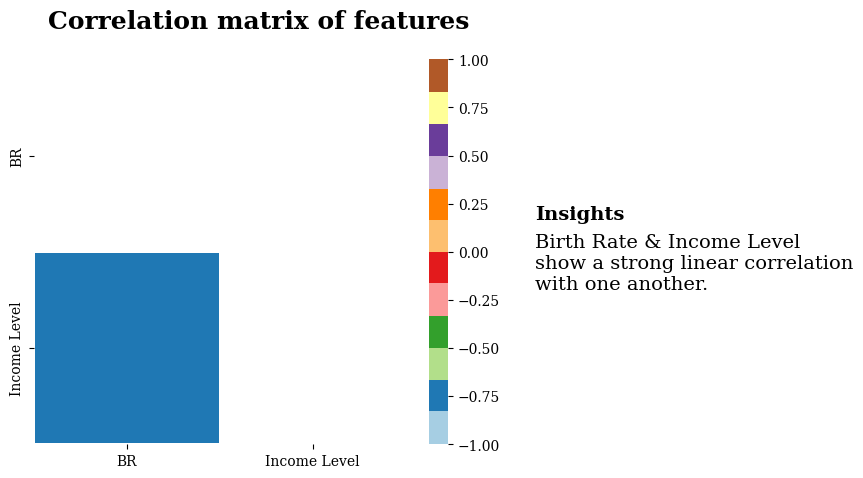

In [10]:
# Prepare data for visualization
df = pd.DataFrame(year2020, columns=['BR', 'Income Level'])
corr = df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(6, 5))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = plt.get_cmap('Paired')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.25)
fig.suptitle('Correlation matrix of features', fontsize=18, fontweight='bold')

fig.text(0.96, 0.56, "Insights", fontfamily='serif', fontweight='bold', fontsize=14)
fig.text(0.96, 0.42, 
         '''Birth Rate & Income Level
show a strong linear correlation
with one another.''',  fontfamily='serif', fontsize=14)

del cmap, df, fig, mask, ax

We find that countries with High Income Level tend to have lower Birth Rates, indicating a negative correlation between the two.  
This phenomenon is referred to as **Multicollinearity** when features in regression model are correlated.  

Consequently, the individual regression coefficients become less reliable, making it difficult to determine the precise impact on Life Expectancy.  
However, despite this challenge, the predictions made on the response variable remain dependable.

## 6. K-means clustering of countries  
We will now implement K-means clustering to group countries into 3 clusters.

In [11]:
# Clustering function
def find_clusters(X, n_clusters=3, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    # This loop continues until convergence.
    while True:
        # Assign labels based on closest center
        # using the pairwise_distances_argmin method to
        # calculate distances between points to centres
        labels = pairwise_distances_argmin(X, centers)
        
        # Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        # Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

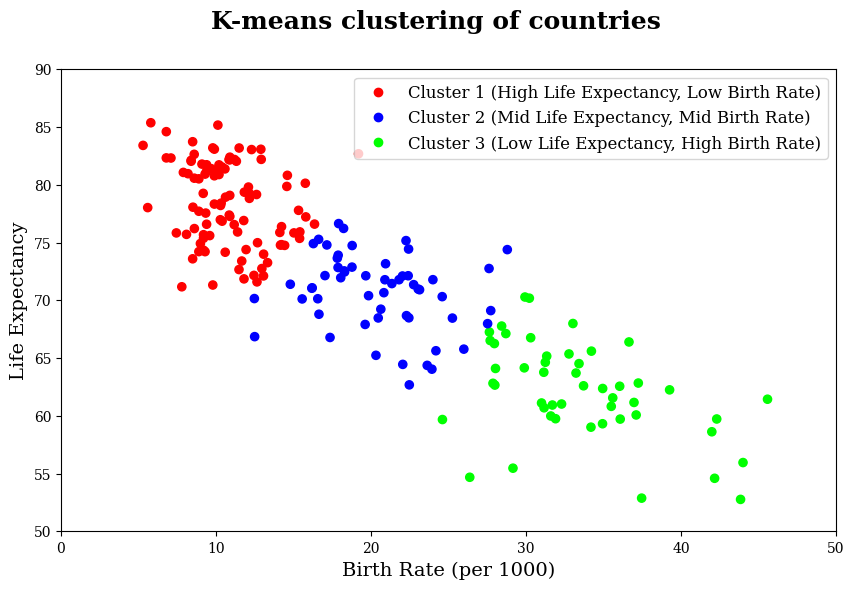

In [34]:
# Visualize clusters of countries in the year 2020
x = year2020['BR'].values
y = year2020['LE'].values

X = np.vstack((x, y)).T
centers, labels = find_clusters(X)

# Draw the scatter plot
fig,axs = plt.subplots(figsize=(10,6))
plt.rcParams['font.family'] = 'serif'

scatter_plot = axs.scatter(X[:, 0], X[:, 1], c=labels, s=35, cmap='brg')
# Define the desired order of labels
label_order = [1, 0, 2]
label_names = ['Cluster 1 (High Life Expectancy, Low Birth Rate)', 
               'Cluster 2 (Mid Life Expectancy, Mid Birth Rate)', 
               'Cluster 3 (Low Life Expectancy, High Birth Rate)']

# Create handles and labels based on the desired order
legend_handles = [scatter_plot.legend_elements()[0][label_order[i]] for i in range(len(label_order))]
legend_labels = [label_names[i] for i in range(len(label_order))]
plt.legend(handles=legend_handles, labels=legend_labels, fontsize=12, loc='upper right')

axs.set_xlabel('Birth Rate (per 1000)', fontsize=14)
axs.set_ylabel('Life Expectancy', fontsize=14)
axs.set_xlim([0, 50])
axs.set_ylim([50, 90])

fig.suptitle('K-means clustering of countries', fontsize=18, fontweight='bold')

del X, x, y, scatter_plot, axs, fig, label_order, label_names, legend_handles, legend_labels


We successfully clustered countries into the following 3 clusters:  
> Cluster 1: Countries with Low Birth Rate and High Life Expectancy   
> Cluster 2: Countries with Medium Birth Rate and Medium Life Expectancy  
> Cluster 3: Countries with High Birth Rate and Low Life Expectancy  

It would also be interesting to see how Income Level and Geographical Regions are divided bteween each clusters.  

## 7. Region and Income Type Distribution in each Cluster

In [13]:
# Prepare 2020 data for visualization
x = year2020['BR'].values
y = year2020['LE'].values
countries = year2020['Country Name'].values

X = np.vstack((x, y)).T
centers, labels = find_clusters(X)

del x,y, X

# Get clusters & labels for year 
print("\nNumber of countries in each cluster:")
print(Counter(labels))

# Create a dictionary with the cluster names as keys and the corresponding country names as values
clusters = {}
for i, k in enumerate(labels):
    cluster_name = 'Cluster' + str(k+1)
    if cluster_name in clusters:
        clusters[cluster_name].append(countries[i])
    else:
        clusters[cluster_name] = [countries[i]]

# Create a list of dataframes, one for each cluster
dfs = []
for k in clusters.keys():
    df = pd.DataFrame({'Cluster Name': [k] * len(clusters[k]), 'Country Name': clusters[k]})
    dfs.append(df)

# Concatenate the dataframes vertically
new_df = pd.concat(dfs, ignore_index=True)

# Use merge() to combine the dataframes based on the 'Country Name' column
year2020_cluster = pd.merge(new_df, year2020[['Country Name','Region', 'Income Group']], on='Country Name', how='left')
year2020_cluster = year2020_cluster.sort_values(by='Cluster Name')

mapping = {'Cluster1': 'Cluster 2', 'Cluster2': 'Cluster 1', 'Cluster3': 'Cluster 3'}
year2020_cluster['Cluster Name'] = year2020_cluster['Cluster Name'].replace(mapping)

del clusters, dfs, new_df, i, k, cluster_name, mapping


Number of countries in each cluster:
Counter({1: 99, 0: 56, 2: 49})


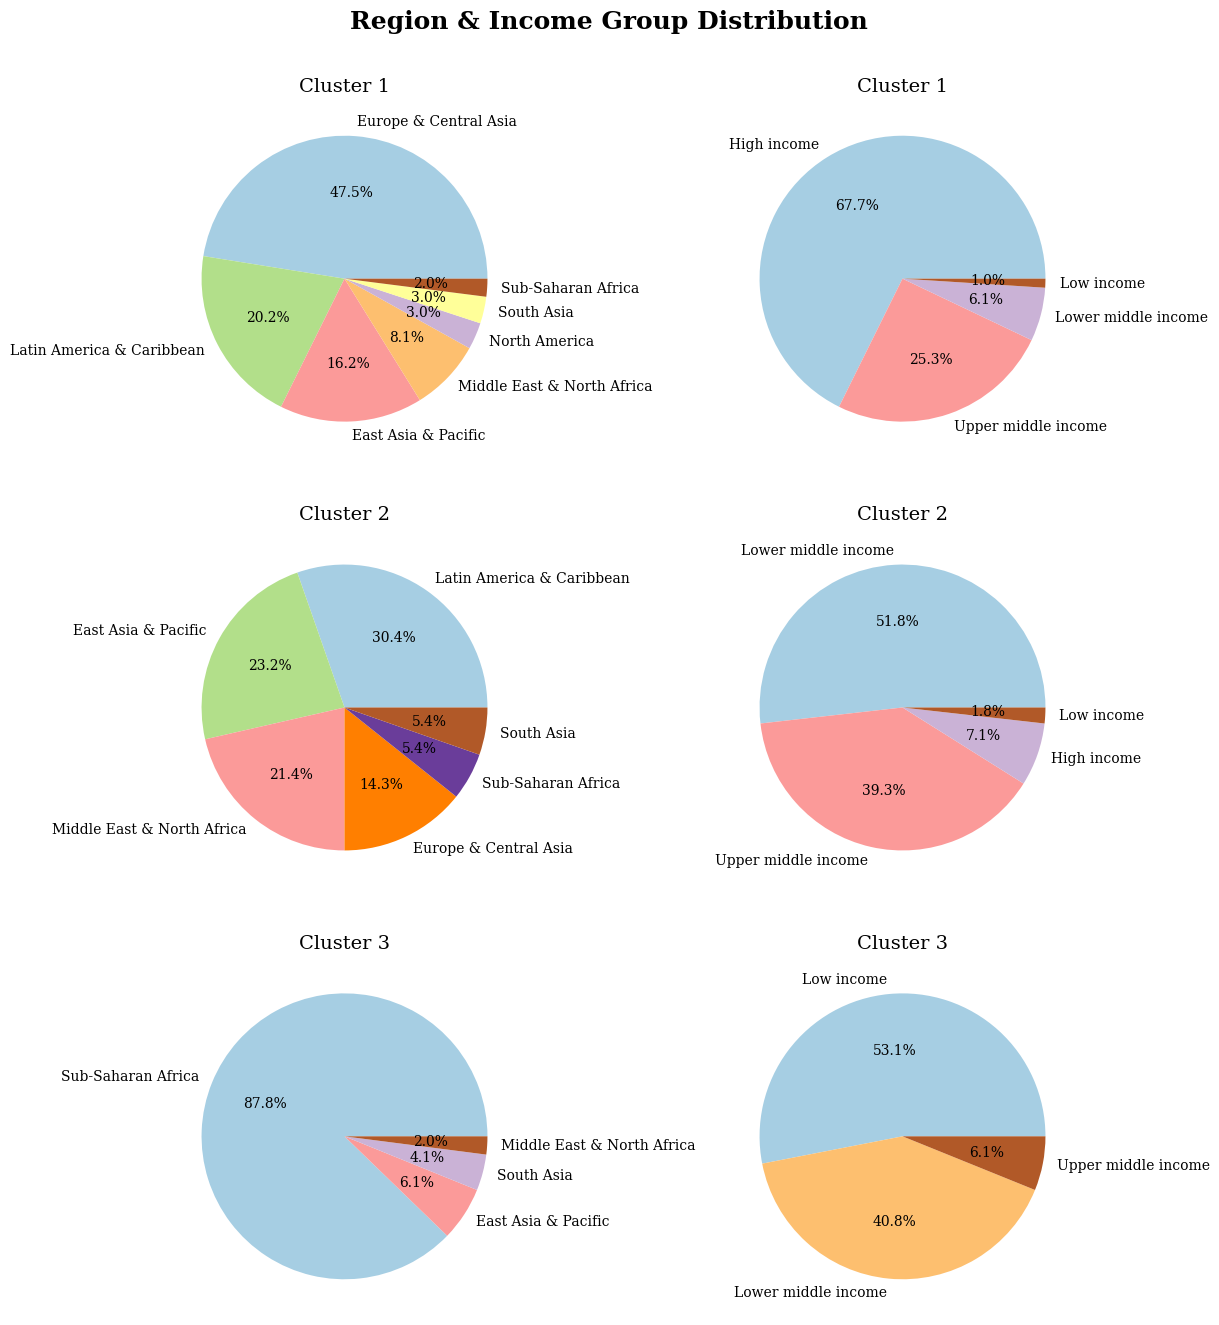

In [14]:
# Generate a list of colors of length n
def generate_colors(n):
    # Use a colormap to generate n colors
    cmap = plt.get_cmap('Paired')
    colors = cmap(np.linspace(0, 1, n))
    # Convert the RGBA values to hex strings
    hex_colors = [to_hex(c) for c in colors]
    return hex_colors
    
# Pie-Chart Distribution
fig, axs = plt.subplots(3,2,figsize=(12,15))
plt.rcParams['font.family'] = 'serif'
row1_idx = 0
row2_idx = 0

year2020_cluster = year2020_cluster.sort_values(by='Cluster Name')

# loop through each unique value in col1
for val in year2020_cluster['Cluster Name'].unique():
    # filter the dataframe to get only the rows with the current value in col1
    subset= year2020_cluster[year2020_cluster['Cluster Name']==val]
    # count the number of occurrences of each unique value in col2 and col3
    counts2 = subset['Region'].value_counts()
    n1 = len(counts2)
    colors1 = generate_colors(n1)
    # plot a pie chart for col2
    axs[row1_idx, 0 ].pie(counts2.values, labels=counts2.index, colors=colors1, autopct='%1.1f%%')
    axs[row1_idx, 0 ].set_title(val, fontsize=14)
    row1_idx = row1_idx + 1

for val in year2020_cluster['Cluster Name'].unique():
    # filter the dataframe to get only the rows with the current value in col1
    subset= year2020_cluster[year2020_cluster['Cluster Name']==val]
    # count the number of occurrences of each unique value in col2 and col3
    counts3 = subset['Income Group'].value_counts()
    n1 = len(counts3)
    colors1 = generate_colors(n1)
    # plot a pie chart for col2
    axs[row2_idx, 1].pie(counts3.values, labels=counts3.index, colors=colors1, autopct='%1.1f%%')
    axs[row2_idx, 1].set_title(val, fontsize=14)
    row2_idx = row2_idx + 1

plt.subplots_adjust(hspace=0.2, wspace = 0.50, top=0.92)

fig.suptitle('Region & Income Group Distribution', fontsize=18, fontweight='bold')
plt.show()

del row1_idx, row2_idx, fig, axs, subset, counts2, counts3, colors1, n1, val


Within each cluster, there is a prevailing income group distribution.  
In Cluster 1, the majority of countries fall into the high to upper middle income category.  
In Cluster 3, the majority of counteries fall into low to lower middle income category.

## Conclusion
In this notebook, we developed a model to predict Life Expectancy in different countries and identified a strong correlation between Birth Rate and Life Expectancy.    
The model achieved an accuracy of 76% when considering Birth Rate as the sole predictor, and 80% when both Birth Rate and Income Level were used as predictors. Incorporating income level as a second predictor did not significantly improve the model's accuracy due to the negative correlation between Birth Rate and Income Level.  

Additionally, we categorized countries into three clusters.  
These clusters provide a basis for further exploration of factors influencing variations in Life Expectancy and Birth Rate among countries within each cluster.  
For instance, low Life Expectancy and high Birth Rate may arise from elevated mortality rates among children and young individuals.  
Conversely, a low Birth Rate in high-income countries could indicate a population decline.  
Conducting additional research may uncover other potential variables that impact the relationship between these factors.

By understanding these factors, governments and policymakers can make well-informed decisions, implement targeted public health policies, and introduce programs tailored to the specific needs of each cluster.


